<a href="https://colab.research.google.com/github/serereuk/transformer/blob/master/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


# 텐서플로우 2.0 과 함께하는 Transformer 구현

## 목차

1. 데이터 확인
2. 데이터 전처리 
3. 모델 구현
4. 실험 결과 확인


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive/information/CNN, RNN/RNN dataset'

/content/drive/My Drive/information/CNN, RNN/RNN dataset


In [0]:
import re
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Softmax, Dense, LayerNormalization
import nltk.translate.bleu_score as bleu

# 1. 2.  데이터 확인 및 전처리

In [0]:
def Reader(file_path, start_token=False):
    """
    #input : file_path, start_token(시작, 끝을 붙일 것인지)  
    #output : string lists which are split by \t 
    """
    data = open(file_path, 'r').readlines()
    en = []; fr = []
    for i in data:
        temp = i.strip().split('\t')
        if start_token:
            en.append('<시작> ' + temp[0] + ' <끝>')
            fr.append('<시작> ' + temp[1] + ' <끝>')
        else:
            en.append(temp[0])
            fr.append(temp[1])
    return en, fr

def tokenizer(data, max_len=30, tok=None):
    """
    #input :  
    data = list of strings, max_len = one sentence max length,
    tok = reuse the pretrained tokenizer  
    #output : max_len padded tokens, tokenizer
    """
    if tok == None:
        tok = Tokenizer(filters='')
        tok.fit_on_texts(data)
    tensor = tok.texts_to_sequences(data)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=max_len, padding='post')
    return tensor, tok

def loss_function(real, pred):
  filters = tf.math.logical_not(tf.math.equal(real, 0))
  loss_final = loss_object(real, pred)
  filters = tf.cast(filters, dtype=loss_final.dtype)
  loss_final *= filters
  return tf.reduce_mean(loss_final)

In [0]:
train_en, train_fr = Reader('eng-fra_train.txt')
test_en, test_fr = Reader('eng-fra_test.txt')
train_en_tokened, en_tok = tokenizer(train_en)
train_fr_tokened, fr_tok = tokenizer(train_fr)
test_en_tokened, _ = tokenizer(test_en, tok=en_tok)
test_fr_tokened, _ = tokenizer(test_fr, tok=fr_tok)
train_dataset = tf.data.Dataset.from_tensor_slices((train_en_tokened, train_fr_tokened)).shuffle(64)
train_dataset = train_dataset.batch(64)

# 3. 모델 구현

* Attention 레이어

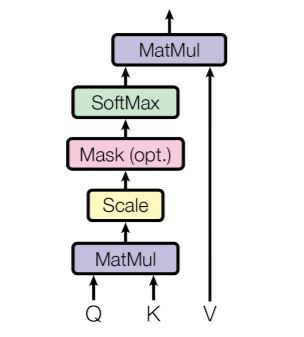

In [0]:
class attention(tf.keras.layers.Layer):
    
    def __init__(self):
        super(attention, self).__init__()
        self.softmax = Softmax()

    def call(self, q, k, v, mask=None):
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        x = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(dk)
        if mask is not None:
            mask = mask * -1e9
            x = mask * x
        x = self.softmax(x)
        x = tf.matmul(x, v)
        return x

* Testbench

In [8]:
a = attention()
x = tf.random.uniform((1, 40))
a(x, x, x)

<tf.Tensor: shape=(1, 40), dtype=float32, numpy=
array([[0.9169905 , 0.39858544, 0.36753404, 0.1292957 , 0.30794728,
        0.28432095, 0.12074292, 0.5967202 , 0.5781256 , 0.30910957,
        0.48590243, 0.37654114, 0.9745835 , 0.85079575, 0.31072056,
        0.35227346, 0.9836036 , 0.6869241 , 0.16483545, 0.42571843,
        0.97651374, 0.0858506 , 0.18161678, 0.4116273 , 0.18452466,
        0.8129555 , 0.20498204, 0.8421463 , 0.53643143, 0.31394434,
        0.83025837, 0.6458336 , 0.64937615, 0.8775265 , 0.10859072,
        0.07327926, 0.39898908, 0.29134977, 0.8010217 , 0.51385784]],
      dtype=float32)>

* Multi_head_attention 구현  
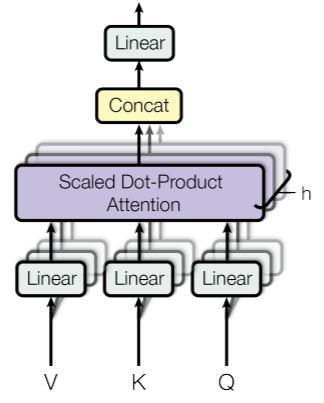

In [0]:
class multi_head_attention(tf.keras.layers.Layer):

    def __init__(self, count=8):
        super(multi_head_attention, self).__init__()
        self.dense_q = [Dense(64) for _ in range(count)]
        self.dense_k = [Dense(64) for _ in range(count)]
        self.dense_v = [Dense(64) for _ in range(count)]
        self.dense_o = Dense(512)
        self.attention = attention()

    def call(self, q, k, v, mask=None):
        q_out = [dense(q) for dense in self.dense_q]
        k_out = [dense(k) for dense in self.dense_k]
        v_out = [dense(v) for dense in self.dense_v]
        x = []
        if mask is not None:
            for qq, kk, vv in zip(q_out, k_out, v_out):
                x.append(self.attention(qq, kk, vv, mask))
        else:
            for qq, kk, vv in zip(q_out, k_out, v_out):
                x.append(self.attention(qq, kk, vv))
        #print(x)
        x = tf.concat(x, axis=2)
        return self.dense_o(x)


* Testbench

In [10]:
a = multi_head_attention(count=8)
y = tf.random.uniform((1, 60, 512)) 
a(y, y, y).shape

TensorShape([1, 60, 512])

* Position_wise_Feed_forward_network 구현

$FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$

In [0]:
class position_wise_nn(tf.keras.layers.Layer):

    def __init__(self):
        super(position_wise_nn, self).__init__()
        self.dense1 = Dense(2048, activation='relu')
        self.dense2 = Dense(512)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

* Testbench

In [12]:
a = position_wise_nn()
x = tf.random.uniform((1, 512))
a(x).shape

TensorShape([1, 512])

* ADD and Norm 구현


In [0]:
class add_norm(tf.keras.layers.Layer):

    def __init__(self):
        super(add_norm, self).__init__()
        self.layer1 = LayerNormalization()

    def call(self, x, y):
        x = self.layer1(x + y)
        return x

* Testbench

In [14]:
a = add_norm()
x = tf.random.uniform((1, 40))
a(x, x)

<tf.Tensor: shape=(1, 40), dtype=float32, numpy=
array([[-0.71105117, -1.5910966 ,  0.39118087,  0.87194896, -0.75123924,
        -0.82517153,  0.06980352, -0.89895105,  0.79216576, -0.8514547 ,
        -0.62265337, -0.8306597 ,  0.6789889 , -0.3082677 ,  0.9720212 ,
        -0.351614  ,  0.30366057, -1.7264097 , -1.6393402 ,  0.27837294,
        -0.2686471 ,  1.3922395 ,  0.7778279 ,  0.49444875, -0.9088851 ,
        -0.3868617 ,  1.7843473 ,  0.91991687,  1.5196586 ,  0.35316464,
        -0.07771717, -1.6950611 , -0.92302305,  1.4431005 , -0.10578916,
        -0.20137542,  1.4674767 ,  0.98747605,  1.613968  , -1.4364971 ]],
      dtype=float32)>

* Position_Encoding 구현

$PE(pos, 2i) = sin(pos/10000^{2i/d_{model}})$  
$PE(pos, 2i+1) = sin(pos/10000^{2i/d_{model}})$

In [0]:
def angles(pos, i, d_model):
    angle = 1/np.power(10000, (2*(i//2) / np.float32(d_model)))
    return pos * angle

def position_encoding(pos, d):
    temp = angles(np.arange(pos)[:, np.newaxis], np.arange(d)[np.newaxis, :], d)
    temp[:, 0::2] = np.sin(temp[:, 0::2])
    temp[:, 1::2] = np.cos(temp[:, 1::2])
    temp = temp[np.newaxis, ...]
    return tf.cast(temp, dtype=tf.float32)


* Encoder, Decoder 구현  

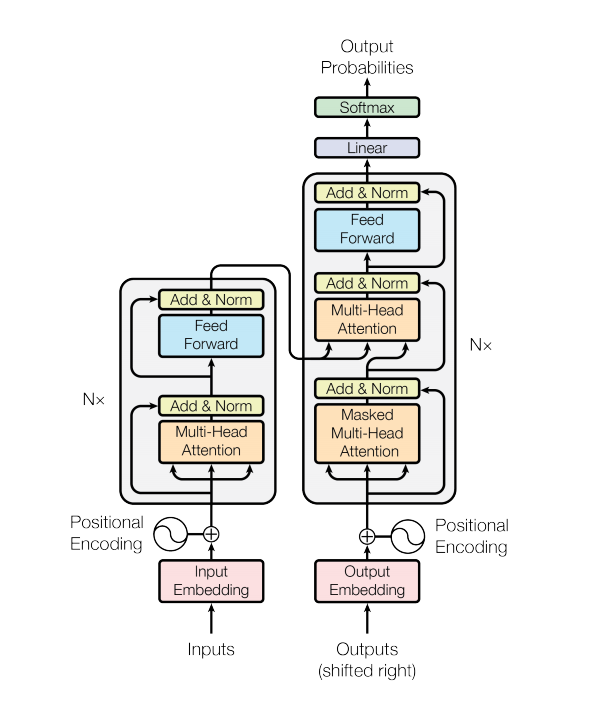

In [0]:
class encoder(tf.keras.layers.Layer):

    def __init__(self):
        super(encoder, self).__init__()
        self.layer1 = multi_head_attention()
        self.layer2 = add_norm()
        self.layer3 = position_wise_nn()
        self.layer4 = add_norm()

    def call(self, x):
        y = self.layer1(x, x, x)
        y = self.layer2(y, x)
        z = self.layer3(y)
        z = self.layer4(z, z)
        return z

In [0]:
class decoder(tf.keras.layers.Layer):

    def __init__(self):
        super(decoder, self).__init__()
        self.layer1 = multi_head_attention()
        self.layer2 = add_norm()
        self.layer3 = multi_head_attention()
        self.layer4 = add_norm()
        self.layer5 = position_wise_nn()
        self.layer6 = add_norm()

    def call(self, x, y, mask):
        z = self.layer1(x, x, x, mask)
        z = self.layer2(z, x)
        w = self.layer3(z, y, y)
        w = self.layer4(w, z)
        xx = self.layer5(w)
        xx = self.layer6(xx, w)
        return xx

* Encoder 블록 구현

In [0]:
class encoders(tf.keras.layers.Layer):

    def __init__(self, vocab_size, d_model, pos, block_num=2):
        super(encoders, self).__init__()
        self.embed = Embedding(vocab_size, d_model)
        self.position = position_encoding(pos, d_model)
        self.encoder_block = [encoder() for _ in range(block_num)]
        self.block_num = block_num

    def call(self, x):
        seq_len = tf.shape(x)[1]
        x = self.embed(x)
        x += self.position[:, :seq_len, :]
        for i in range(self.block_num):
            x = self.encoder_block[i](x)
        return x

* Decoder 블록 구현


In [0]:
class decoders(tf.keras.layers.Layer):

    def __init__(self, vocab_size, d_model, pos, block_num=2):
        super(decoders, self).__init__()
        self.embed = Embedding(vocab_size, d_model)
        self.position = position_encoding(pos, d_model)
        self.decoder_block = [decoder() for _ in range(block_num)]
        self.block_num = block_num

    def call(self, x, enc_out, mask):
        seq_len = tf.shape(x)[1]
        x = self.embed(x)
        x += self.position[:, :seq_len, :]
        for i in range(self.block_num):
            x = self.decoder_block[i](x, enc_out, mask)
        return x

* Transformer 구현

In [0]:
class Transformer(tf.keras.Model):

    def __init__(self, encoder_vocab, decoder_vocab, d_model, en_pos, de_pos, block_num=2):
        super(Transformer, self).__init__()
        self.encoded = encoders(encoder_vocab, d_model, en_pos, block_num)
        self.decoded = decoders(decoder_vocab, d_model, de_pos, block_num)
        self.dense1 = Dense(decoder_vocab)

    def call(self, x, y, mask):
        encoder_out = self.encoded(x)
        decoder_out = self.decoded(y, encoder_out, mask)
        logits = self.dense1(decoder_out)
        return logits

* Testbench

In [0]:
model = Transformer(1000, 1000, 512, 1000, 1000, 2)

In [0]:
temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

In [23]:
model(temp_input, temp_target, mask=None).shape

TensorShape([64, 36, 1000])

* Masking look_ahead_mask

In [0]:
"""
reference from https://www.tensorflow.org/tutorials/text/transformer
"""
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [25]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

Args:  
    * input: A Tensor. Rank k tensor.  
    * num_lower: A Tensor. Must be one of the following types: int32, int64. 0-D tensor. Number of subdiagonals to keep. If negative, keep entire lower triangle.  
    * num_upper: A Tensor. Must have the same type as num_lower. 0-D tensor. Number of superdiagonals to keep. If negative, keep entire upper triangle.

In [26]:
tf.linalg.band_part(tf.ones((3, 3)), -1, 0)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

In [0]:
input_vocab_size = len(en_tok.word_docs) + 2
target_vocab_size = len(fr_tok.word_docs) + 2

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(512)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [0]:
model = Transformer(input_vocab_size, target_vocab_size, 512, input_vocab_size, target_vocab_size, 2)

In [0]:
@tf.function()
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
  
  with tf.GradientTape() as tape:
    predictions = model(inp, tar_inp, mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, model.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [42]:
for epoch in range(10):
  #train_loss.reset_states()
  #train_accuracy.reset_states()
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))


Epoch 1 Batch 0 Loss 0.5618 Accuracy 0.0000
Epoch 1 Batch 50 Loss 1.0214 Accuracy 0.0149
Epoch 1 Batch 100 Loss 1.1491 Accuracy 0.0200
Epoch 1 Loss 1.1721 Accuracy 0.0205
Epoch 2 Batch 0 Loss 1.1653 Accuracy 0.0203
Epoch 2 Batch 50 Loss 1.0529 Accuracy 0.0205
Epoch 2 Batch 100 Loss 1.0706 Accuracy 0.0245
Epoch 2 Loss 1.0807 Accuracy 0.0249
Epoch 3 Batch 0 Loss 1.0782 Accuracy 0.0248
Epoch 3 Batch 50 Loss 1.0193 Accuracy 0.0243
Epoch 3 Batch 100 Loss 1.0266 Accuracy 0.0267
Epoch 3 Loss 1.0327 Accuracy 0.0269
Epoch 4 Batch 0 Loss 1.0312 Accuracy 0.0269
Epoch 4 Batch 50 Loss 0.9928 Accuracy 0.0264
Epoch 4 Batch 100 Loss 0.9978 Accuracy 0.0284
Epoch 4 Loss 1.0025 Accuracy 0.0286
Epoch 5 Batch 0 Loss 1.0014 Accuracy 0.0286
Epoch 5 Batch 50 Loss 0.9733 Accuracy 0.0282
Epoch 5 Batch 100 Loss 0.9763 Accuracy 0.0300
Epoch 5 Loss 0.9795 Accuracy 0.0303
Epoch 6 Batch 0 Loss 0.9788 Accuracy 0.0302
Epoch 6 Batch 50 Loss 0.9541 Accuracy 0.0305
Epoch 6 Batch 100 Loss 0.9473 Accuracy 0.0341
Epoch 6 Lo